# 1. Install Dependencies (including PEFT for LoRA)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets librosa soundfile evaluate accelerate peft kagglehub --quiet

import os
import glob
import numpy as np
import pandas as pd
import librosa
import torch
import kagglehub
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset
from transformers import (
    Wav2Vec2FeatureExtractor,
    HubertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from peft import get_peft_model, LoraConfig, TaskType

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


# 2. Download Datasets


In [3]:
print("Downloading Datasets...")
ravdess_path = kagglehub.dataset_download("orvile/ravdess-dataset")
crema_path = kagglehub.dataset_download("ejlok1/cremad")
tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

def get_combined_data(ravdess, crema, tess):
    paths = []
    emotions = []

    # 1. RAVDESS
    e_map_r = {"01": "neutral", "02": "neutral", "03": "happy", "04": "sad",
               "05": "angry", "06": "fearful", "07": "disgust", "08": "happy"}
    for p in glob.glob(os.path.join(ravdess, "**", "*.wav"), recursive=True):
        code = os.path.basename(p).split('-')[2]
        if code in e_map_r:
            paths.append(p)
            emotions.append(e_map_r[code])

    # 2. CREMA-D
    e_map_c = {"A": "angry", "D": "disgust", "F": "fearful", "H": "happy", "N": "neutral", "S": "sad"}
    for p in glob.glob(os.path.join(crema, "**", "*.wav"), recursive=True):
        code = os.path.basename(p).split('_')[2]
        if code[0] in e_map_c:
            paths.append(p)
            emotions.append(e_map_c[code[0]])

    # 3. TESS
    for p in glob.glob(os.path.join(tess, "**", "*.wav"), recursive=True):
        filename = os.path.basename(p)
        emotion = filename.split('_')[-1].replace('.wav', '').lower()
        if emotion == "ps": emotion = "happy" # pleasant surprise -> happy
        paths.append(p)
        emotions.append(emotion)

    df = pd.DataFrame({"path": paths, "emotion": emotions})
    df['emotion'] = df['emotion'].replace({
        "fear": "fearful",  # Merge TESS 'fear' into 'fearful'
        "sadness": "sad",   # Just in case TESS uses 'sadness'
        "happiness": "happy"
    })

    return df

df = get_combined_data(ravdess_path, crema_path, tess_path)
print(f"Total samples: {len(df)}")

# Label Mapping
label2id = {
    "angry": 0,
    "disgust": 1,
    "fearful": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5
}
id2label = {v: k for k, v in label2id.items()}
df['label'] = df['emotion'].map(label2id)

# Split (Stratified to ensure balanced classes)
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['emotion'])

100%|██████████| 23.9G/23.9G [18:36<00:00, 22.9MB/s]

Extracting files...


100%|██████████| 451M/451M [00:21<00:00, 22.5MB/s]

Extracting files...


Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Total samples: 15494


# 3. Optimized Dataset Class

In [4]:
import random

# Initialize Feature Extractor
model_id = "facebook/hubert-large-ls960-ft"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_id)

class EnhancedSERDataset(Dataset):
    def __init__(self, dataframe, processor, target_sr=16000, max_seconds=5, augment=False):
        self.paths = dataframe['path'].tolist()
        self.labels = dataframe['label'].tolist()
        self.processor = processor
        self.target_sr = target_sr
        self.max_len = target_sr * max_seconds
        self.augment = augment

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # 1. Load audio
        speech, sr = librosa.load(self.paths[idx], sr=self.target_sr)
        speech, _ = librosa.effects.trim(speech, top_db=25)

        # 3. Robust Augmentation (Training ONLY)
        if self.augment:
            # Random Background Noise (Simulates real environment hiss)
            if random.random() > 0.5:
                noise_amp = 0.005 * random.uniform(0, 1) * np.amax(speech)
                speech = speech + noise_amp * np.random.normal(size=speech.shape[0])

            # Pitch Shifting (Simulates different vocal ranges)
            if random.random() > 0.5:
                steps = random.uniform(-1.5, 1.5)
                speech = librosa.effects.pitch_shift(speech, sr=self.target_sr, n_steps=steps)

            # Time Stretching (Simulates speech speed variations)
            if random.random() > 0.5:
                rate = random.uniform(0.8, 1.2)
                speech = librosa.effects.time_stretch(speech, rate=rate)

        # 4. Normalization (Crucial for live mic volume differences)
        speech = librosa.util.normalize(speech)

        # 5. Final Sizing
        if len(speech) > self.max_len:
            speech = speech[:self.max_len]
        else:
            speech = np.pad(speech, (0, self.max_len - len(speech)), mode='constant')

        # 6. Process for Model
        inputs = self.processor(speech, sampling_rate=self.target_sr, return_tensors="pt")

        return {
            "input_values": inputs.input_values[0],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Update dataset initialization to use augmentation ONLY on train
train_ds = EnhancedSERDataset(train_df, feature_extractor, augment=True) # Enable augment
test_ds = EnhancedSERDataset(test_df, feature_extractor, augment=False)  # Keep validation clean

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

# 4. Model Setup with LoRA

In [5]:
from peft import get_peft_model, LoraConfig

# Load Base Model
model = HubertForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

peft_config = LoraConfig(
    inference_mode=False,
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "out_proj",
        "intermediate_act", "dense"
    ],
    modules_to_save=["classifier", "projector"]
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 6,555,398 || all params: 322,258,060 || trainable%: 2.0342


# 5. Training

In [6]:
from transformers.trainer_utils import get_last_checkpoint
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/hubert_lora_ser_final_version2",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=20,
    warmup_ratio=0.1,
    fp16=True,
    save_total_limit=2,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

print("Starting Training with Weighted Loss & SpecAugment...")
output_dir = "/content/drive/MyDrive/hubert_lora_ser_final_version2"

last_checkpoint = None
if os.path.isdir(output_dir):
    last_checkpoint = get_last_checkpoint(output_dir)

if last_checkpoint:
    print(f"Found checkpoint: {last_checkpoint}")
    print("Resuming training from where you left off...")
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    print("No checkpoint found in Drive. Starting from scratch...")
    trainer.train()

Starting Training with Weighted Loss & SpecAugment...
Found checkpoint: /content/drive/MyDrive/hubert_lora_ser_final_version2/checkpoint-12360
Resuming training from where you left off...


Epoch,Training Loss,Validation Loss,Accuracy
16,0.373400,0.278080,0.905376
17,0.350400,0.295212,0.906237
18,0.343900,0.292157,0.907957
19,0.332100,0.280382,0.910968
20,0.330600,0.271139,0.911398


# 6. Final Evaluation

In [7]:
preds = trainer.predict(test_ds)
print(classification_report(preds.label_ids, np.argmax(preds.predictions, axis=1), target_names=list(label2id.keys())))

              precision    recall  f1-score   support

       angry       0.94      0.96      0.95       367
     disgust       0.94      0.89      0.92       340
     fearful       0.87      0.87      0.87       367
       happy       0.95      0.96      0.95       516
     neutral       0.88      0.99      0.93       368
         sad       0.88      0.77      0.82       367

    accuracy                           0.91      2325
   macro avg       0.91      0.91      0.91      2325
weighted avg       0.91      0.91      0.91      2325



In [8]:
from google.colab import drive

# 2. Save the model
trainer.save_model("/content/drive/MyDrive/hubert_lora_ser_final_version2")
feature_extractor.save_pretrained("/content/drive/MyDrive/hubert_lora_ser_final_version2")

['/content/drive/MyDrive/hubert_lora_ser_final_version2/preprocessor_config.json']

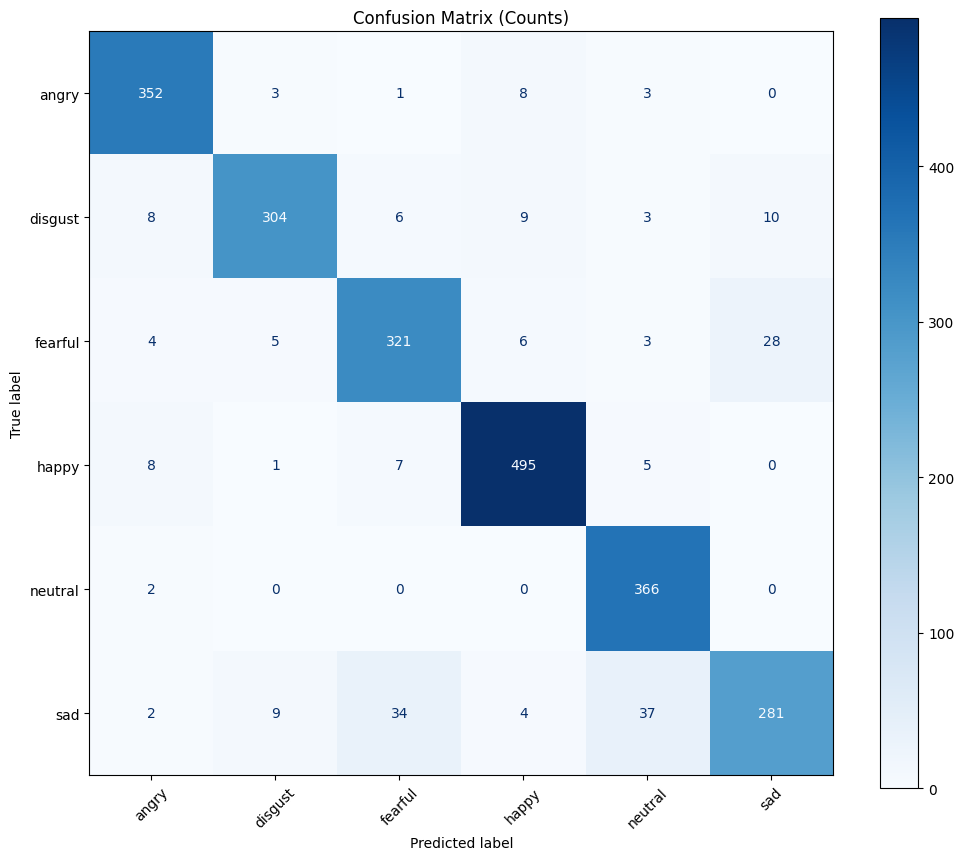

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get Predictions
preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# 2. Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plot
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))

disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)

plt.title("Confusion Matrix (Counts)")
plt.xticks(rotation=45)
plt.show()